In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image as im
from scipy.ndimage import interpolation as inter
import imutils

from scipy.spatial import distance as dist
from matplotlib.patches import Polygon
#import polygon_interacter as poly_i
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
import cv2
from pylsd.lsd import lsd

In [2]:
 from scipy.spatial import distance as dist
import numpy as np
import cv2

def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
 
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
 
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
 
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
 
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype = "float32")

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [3]:
def translate(image, x, y):
	# Define the translation matrix and perform the translation
	M = np.float32([[1, 0, x], [0, 1, y]])
	shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

	# Return the translated image
	return shifted

def rotate(image, angle, center = None, scale = 1.0):
	# Grab the dimensions of the image
	(h, w) = image.shape[:2]

	# If the center is None, initialize it as the center of
	# the image
	if center is None:
		center = (w / 2, h / 2)

	# Perform the rotation
	M = cv2.getRotationMatrix2D(center, angle, scale)
	rotated = cv2.warpAffine(image, M, (w, h))

	# Return the rotated image
	return rotated

def resize(image, width = None, height = None, inter = cv2.INTER_AREA):
	# initialize the dimensions of the image to be resized and
	# grab the image size
	dim = None
	(h, w) = image.shape[:2]

	# if both the width and height are None, then return the
	# original image
	if width is None and height is None:
		return image

	# check to see if the width is None
	if width is None:
		# calculate the ratio of the height and construct the
		# dimensions
		r = height / float(h)
		dim = (int(w * r), height)

	# otherwise, the height is None
	else:
		# calculate the ratio of the width and construct the
		# dimensions
		r = width / float(w)
		dim = (width, int(h * r))

	# resize the image
	resized = cv2.resize(image, dim, interpolation = inter)

	# return the resized image
	return resized

In [4]:
from matplotlib.lines import Line2D
from matplotlib.artist import Artist


class PolygonInteractor(object):
    """
    An polygon editor
    """

    showverts = True
    epsilon = 5  # max pixel distance to count as a vertex hit

    def __init__(self, ax, poly):
        if poly.figure is None:
            raise RuntimeError('You must first add the polygon to a figure or canvas before defining the interactor')
        self.ax = ax
        canvas = poly.figure.canvas
        self.poly = poly

        x, y = zip(*self.poly.xy)
        self.line = Line2D(x, y, marker='o', markerfacecolor='r', animated=True)
        self.ax.add_line(self.line)

        cid = self.poly.add_callback(self.poly_changed)
        self._ind = None  # the active vert

        canvas.mpl_connect('draw_event', self.draw_callback)
        canvas.mpl_connect('button_press_event', self.button_press_callback)
        canvas.mpl_connect('button_release_event', self.button_release_callback)
        canvas.mpl_connect('motion_notify_event', self.motion_notify_callback)
        self.canvas = canvas

    def get_poly_points(self):
        return np.asarray(self.poly.xy)

    def draw_callback(self, event):
        self.background = self.canvas.copy_from_bbox(self.ax.bbox)
        self.ax.draw_artist(self.poly)
        self.ax.draw_artist(self.line)
        self.canvas.blit(self.ax.bbox)

    def poly_changed(self, poly):
        'this method is called whenever the polygon object is called'
        # only copy the artist props to the line (except visibility)
        vis = self.line.get_visible()
        Artist.update_from(self.line, poly)
        self.line.set_visible(vis)  # don't use the poly visibility state

    def get_ind_under_point(self, event):
        'get the index of the vertex under point if within epsilon tolerance'

        # display coords
        xy = np.asarray(self.poly.xy)
        xyt = self.poly.get_transform().transform(xy)
        xt, yt = xyt[:, 0], xyt[:, 1]
        d = np.sqrt((xt - event.x)**2 + (yt - event.y)**2)
        indseq = np.nonzero(np.equal(d, np.amin(d)))[0]
        ind = indseq[0]

        if d[ind] >= self.epsilon:
            ind = None

        return ind

    def button_press_callback(self, event):
        'whenever a mouse button is pressed'
        if not self.showverts:
            return
        if event.inaxes is None:
            return
        if event.button != 1:
            return
        self._ind = self.get_ind_under_point(event)

    def button_release_callback(self, event):
        'whenever a mouse button is released'
        if not self.showverts:
            return
        if event.button != 1:
            return
        self._ind = None

    def motion_notify_callback(self, event):
        'on mouse movement'
        if not self.showverts:
            return
        if self._ind is None:
            return
        if event.inaxes is None:
            return
        if event.button != 1:
            return
        x, y = event.xdata, event.ydata

        self.poly.xy[self._ind] = x, y
        if self._ind == 0:
            self.poly.xy[-1] = x, y
        elif self._ind == len(self.poly.xy) - 1:
            self.poly.xy[0] = x, y
        self.line.set_data(zip(*self.poly.xy))

        self.canvas.restore_region(self.background)
        self.ax.draw_artist(self.poly)
        self.ax.draw_artist(self.line)
        self.canvas.blit(self.ax.bbox)

In [5]:
 class DocScanner(object):
    """An image scanner"""

    def __init__(self, interactive=False, MIN_QUAD_AREA_RATIO=0.25, MAX_QUAD_ANGLE_RANGE=40):
        """
        Args:
            interactive (boolean): If True, user can adjust screen contour before
                transformation occurs in interactive pyplot window.
            MIN_QUAD_AREA_RATIO (float): A contour will be rejected if its corners 
                do not form a quadrilateral that covers at least MIN_QUAD_AREA_RATIO 
                of the original image. Defaults to 0.25.
            MAX_QUAD_ANGLE_RANGE (int):  A contour will also be rejected if the range 
                of its interior angles exceeds MAX_QUAD_ANGLE_RANGE. Defaults to 40.
        """        
        self.interactive = interactive
        self.MIN_QUAD_AREA_RATIO = MIN_QUAD_AREA_RATIO
        self.MAX_QUAD_ANGLE_RANGE = MAX_QUAD_ANGLE_RANGE        

    def filter_corners(self, corners, min_dist=20):
        """Filters corners that are within min_dist of others"""
        def predicate(representatives, corner):
            return all(dist.euclidean(representative, corner) >= min_dist
                       for representative in representatives)

        filtered_corners = []
        for c in corners:
            if predicate(filtered_corners, c):
                filtered_corners.append(c)
        return filtered_corners

    def angle_between_vectors_degrees(self, u, v):
        """Returns the angle between two vectors in degrees"""
        return np.degrees(
            math.acos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))))

    def get_angle(self, p1, p2, p3):
        """
        Returns the angle between the line segment from p2 to p1 
        and the line segment from p2 to p3 in degrees
        """
        a = np.radians(np.array(p1))
        b = np.radians(np.array(p2))
        c = np.radians(np.array(p3))

        avec = a - b
        cvec = c - b

        return self.angle_between_vectors_degrees(avec, cvec)

    def angle_range(self, quad):
        """
        Returns the range between max and min interior angles of quadrilateral.
        The input quadrilateral must be a numpy array with vertices ordered clockwise
        starting with the top left vertex.
        """
        tl, tr, br, bl = quad
        ura = self.get_angle(tl[0], tr[0], br[0])
        ula = self.get_angle(bl[0], tl[0], tr[0])
        lra = self.get_angle(tr[0], br[0], bl[0])
        lla = self.get_angle(br[0], bl[0], tl[0])

        angles = [ura, ula, lra, lla]
        return np.ptp(angles)          

    def get_corners(self, img):
        """
        Returns a list of corners ((x, y) tuples) found in the input image. With proper
        pre-processing and filtering, it should output at most 10 potential corners.
        This is a utility function used by get_contours. The input image is expected 
        to be rescaled and Canny filtered prior to be passed in.
        """
        lines = lsd(img)

        # massages the output from LSD
        # LSD operates on edges. One "line" has 2 edges, and so we need to combine the edges back into lines
        # 1. separate out the lines into horizontal and vertical lines.
        # 2. Draw the horizontal lines back onto a canvas, but slightly thicker and longer.
        # 3. Run connected-components on the new canvas
        # 4. Get the bounding box for each component, and the bounding box is final line.
        # 5. The ends of each line is a corner
        # 6. Repeat for vertical lines
        # 7. Draw all the final lines onto another canvas. Where the lines overlap are also corners

        corners = []
        if lines is not None:
            # separate out the horizontal and vertical lines, and draw them back onto separate canvases
            lines = lines.squeeze().astype(np.int32).tolist()
            horizontal_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            vertical_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            for line in lines:
                x1, y1, x2, y2, _ = line
                if abs(x2 - x1) > abs(y2 - y1):
                    (x1, y1), (x2, y2) = sorted(((x1, y1), (x2, y2)), key=lambda pt: pt[0])
                    cv2.line(horizontal_lines_canvas, (max(x1 - 5, 0), y1), (min(x2 + 5, img.shape[1] - 1), y2), 255, 2)
                else:
                    (x1, y1), (x2, y2) = sorted(((x1, y1), (x2, y2)), key=lambda pt: pt[1])
                    cv2.line(vertical_lines_canvas, (x1, max(y1 - 5, 0)), (x2, min(y2 + 5, img.shape[0] - 1)), 255, 2)

            lines = []

            # find the horizontal lines (connected-components -> bounding boxes -> final lines)
            (contours, hierarchy) = cv2.findContours(horizontal_lines_canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)[:2]
            horizontal_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            for contour in contours:
                contour = contour.reshape((contour.shape[0], contour.shape[2]))
                min_x = np.amin(contour[:, 0], axis=0) + 2
                max_x = np.amax(contour[:, 0], axis=0) - 2
                left_y = int(np.average(contour[contour[:, 0] == min_x][:, 1]))
                right_y = int(np.average(contour[contour[:, 0] == max_x][:, 1]))
                lines.append((min_x, left_y, max_x, right_y))
                cv2.line(horizontal_lines_canvas, (min_x, left_y), (max_x, right_y), 1, 1)
                corners.append((min_x, left_y))
                corners.append((max_x, right_y))

            # find the vertical lines (connected-components -> bounding boxes -> final lines)
            (contours, hierarchy) = cv2.findContours(vertical_lines_canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)[:2]
            vertical_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            for contour in contours:
                contour = contour.reshape((contour.shape[0], contour.shape[2]))
                min_y = np.amin(contour[:, 1], axis=0) + 2
                max_y = np.amax(contour[:, 1], axis=0) - 2
                top_x = int(np.average(contour[contour[:, 1] == min_y][:, 0]))
                bottom_x = int(np.average(contour[contour[:, 1] == max_y][:, 0]))
                lines.append((top_x, min_y, bottom_x, max_y))
                cv2.line(vertical_lines_canvas, (top_x, min_y), (bottom_x, max_y), 1, 1)
                corners.append((top_x, min_y))
                corners.append((bottom_x, max_y))

            # find the corners
            corners_y, corners_x = np.where(horizontal_lines_canvas + vertical_lines_canvas == 2)
            corners += zip(corners_x, corners_y)

        # remove corners in close proximity
        corners = self.filter_corners(corners)
        return corners

    def is_valid_contour(self, cnt, IM_WIDTH, IM_HEIGHT):
        """Returns True if the contour satisfies all requirements set at instantitation"""

        return (len(cnt) == 4 and cv2.contourArea(cnt) > IM_WIDTH * IM_HEIGHT * self.MIN_QUAD_AREA_RATIO 
            and self.angle_range(cnt) < self.MAX_QUAD_ANGLE_RANGE)


    def get_contour(self, rescaled_image):
        """
        Returns a numpy array of shape (4, 2) containing the vertices of the four corners
        of the document in the image. It considers the corners returned from get_corners()
        and uses heuristics to choose the four corners that most likely represent
        the corners of the document. If no corners were found, or the four corners represent
        a quadrilateral that is too small or convex, it returns the original four corners.
        """

        # these constants are carefully chosen
        MORPH = 9
        CANNY = 84
        HOUGH = 25

        IM_HEIGHT, IM_WIDTH, _ = rescaled_image.shape

        # convert the image to grayscale and blur it slightly
        gray = cv2.cvtColor(rescaled_image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (7,7), 0)

        # dilate helps to remove potential holes between edge segments
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(MORPH,MORPH))
        dilated = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

        # find edges and mark them in the output map using the Canny algorithm
        edged = cv2.Canny(dilated, 0, CANNY)
        test_corners = self.get_corners(edged)

        approx_contours = []

        if len(test_corners) >= 4:
            quads = []

            for quad in itertools.combinations(test_corners, 4):
                points = np.array(quad)
                points = order_points(points)
                points = np.array([[p] for p in points], dtype = "int32")
                quads.append(points)

            # get top five quadrilaterals by area
            quads = sorted(quads, key=cv2.contourArea, reverse=True)[:5]
            # sort candidate quadrilaterals by their angle range, which helps remove outliers
            quads = sorted(quads, key=self.angle_range)

            approx = quads[0]
            if self.is_valid_contour(approx, IM_WIDTH, IM_HEIGHT):
                approx_contours.append(approx)

            # for debugging: uncomment the code below to draw the corners and countour found 
            # by get_corners() and overlay it on the image

            # cv2.drawContours(rescaled_image, [approx], -1, (20, 20, 255), 2)
            # plt.scatter(*zip(*test_corners))
            # plt.imshow(rescaled_image)
            # plt.show()

        # also attempt to find contours directly from the edged image, which occasionally 
        # produces better results
        (cnts, hierarchy) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

        # loop over the contours
        for c in cnts:
            # approximate the contour
            approx = cv2.approxPolyDP(c, 80, True)
            if self.is_valid_contour(approx, IM_WIDTH, IM_HEIGHT):
                approx_contours.append(approx)
                break

        # If we did not find any valid contours, just use the whole image
        if not approx_contours:
            TOP_RIGHT = (IM_WIDTH, 0)
            BOTTOM_RIGHT = (IM_WIDTH, IM_HEIGHT)
            BOTTOM_LEFT = (0, IM_HEIGHT)
            TOP_LEFT = (0, 0)
            screenCnt = np.array([[TOP_RIGHT], [BOTTOM_RIGHT], [BOTTOM_LEFT], [TOP_LEFT]])

        else:
            screenCnt = max(approx_contours, key=cv2.contourArea)
            
        return screenCnt.reshape(4, 2)

    def interactive_get_contour(self, screenCnt, rescaled_image):
        poly = Polygon(screenCnt, animated=True, fill=False, color="yellow", linewidth=5)
        fig, ax = plt.subplots()
        ax.add_patch(poly)
        ax.set_title(('Drag the corners of the box to the corners of the document. \n'
            'Close the window when finished.'))
        p = PolygonInteractor(ax, poly)
        plt.imshow(rescaled_image)
        plt.show()

        new_points = p.get_poly_points()[:4]
        new_points = np.array([[p] for p in new_points], dtype = "int32")
        return new_points.reshape(4, 2)

    def scan(self, image_path):

        RESCALED_HEIGHT = 500.0
        OUTPUT_DIR = 'output'

        # load the image and compute the ratio of the old height
        # to the new height, clone it, and resize it
        image = cv2.imread(image_path)
        #print(image)
        assert(image is not None)

        ratio = image.shape[0] / RESCALED_HEIGHT
        orig = image.copy()
        rescaled_image = imutils.resize(image, height = int(RESCALED_HEIGHT))

        # get the contour of the document
        screenCnt = self.get_contour(rescaled_image)

        if self.interactive:
            screenCnt = self.interactive_get_contour(screenCnt, rescaled_image)

        # apply the perspective transformation
        warped = four_point_transform(orig, screenCnt * ratio)

        # convert the warped image to grayscale
        gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

        # sharpen image
        sharpen = cv2.GaussianBlur(gray, (0,0), 3)
        sharpen = cv2.addWeighted(gray, 1.5, sharpen, -0.5, 0)

        # apply adaptive threshold to get black and white effect
        thresh = cv2.adaptiveThreshold(sharpen, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 15)
        plt.imshow(thresh)
        
        # save the transformed image
        basename = os.path.basename(image_path)
        print(basename)
        OUTPUT_DIR="E:/ssl_invoice/proccessed"
        #cv2.imwrite(OUTPUT_DIR + '/' + basename, thresh)
        np.save(OUTPUT_DIR,thresh)
        print("Proccessed " + basename)


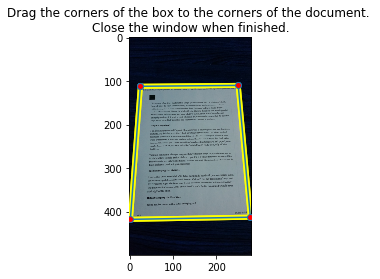

cell_pic.jpg
Proccessed cell_pic.jpg


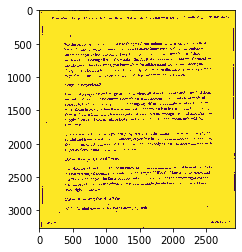

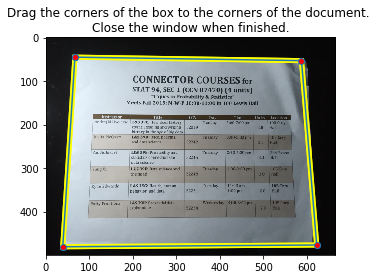

chart.jfif
Proccessed chart.jfif


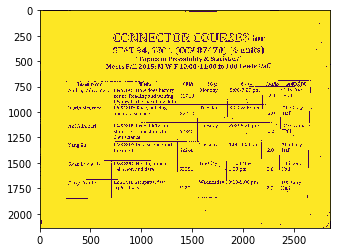

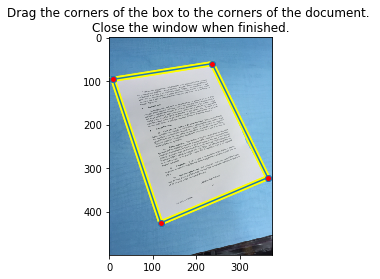

desk.jfif
Proccessed desk.jfif


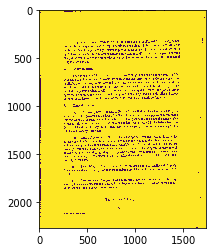

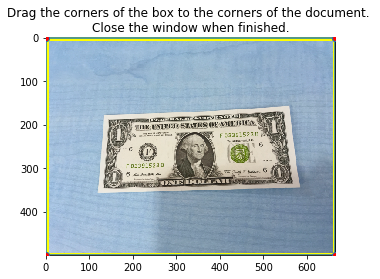

dollar_bill.jfif
Proccessed dollar_bill.jfif


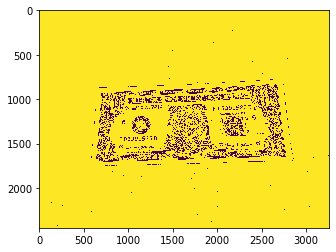

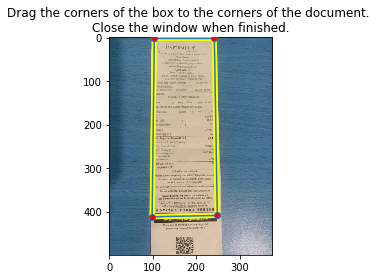

invoice-10.jpg
Proccessed invoice-10.jpg


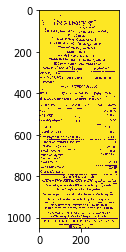

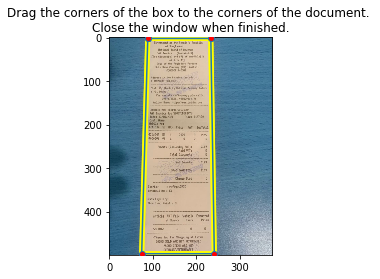

invoice-11.jpg
Proccessed invoice-11.jpg


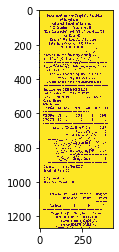

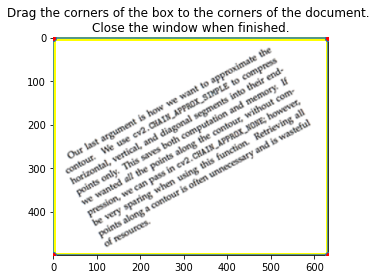

invoice-3.PNG
Proccessed invoice-3.PNG


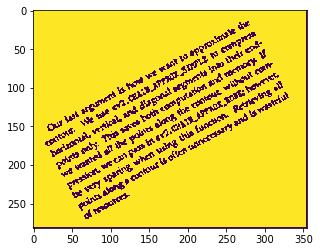

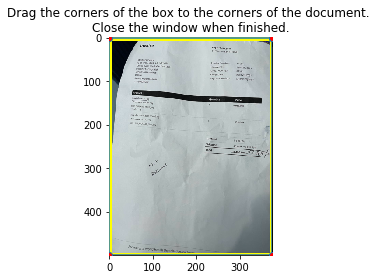

invoice-4.jpg
Proccessed invoice-4.jpg


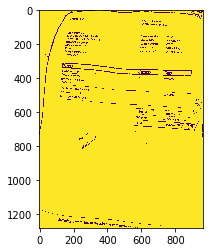

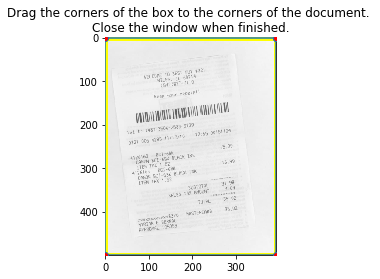

invoice-6.jpg
Proccessed invoice-6.jpg


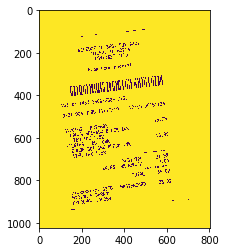

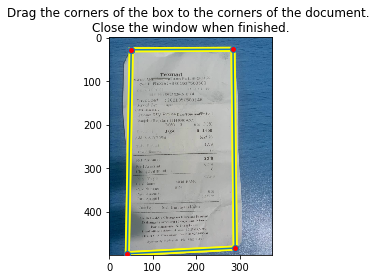

invoice-7.jpg
Proccessed invoice-7.jpg


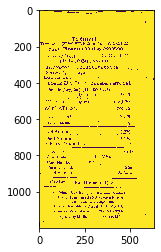

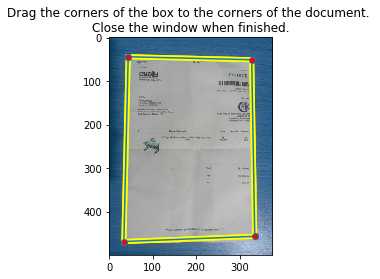

invoice-8.jpg
Proccessed invoice-8.jpg


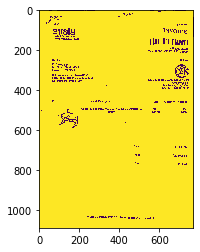

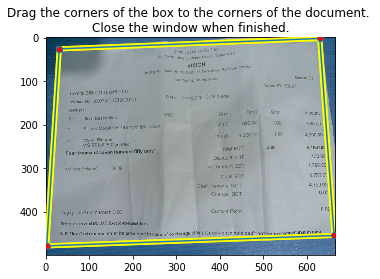

invoice-9.jpg
Proccessed invoice-9.jpg


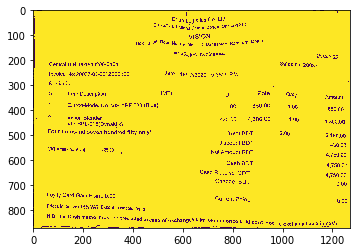

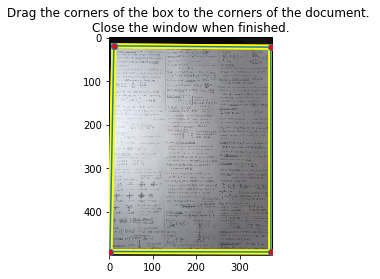

math_cheat_sheet.jfif
Proccessed math_cheat_sheet.jfif


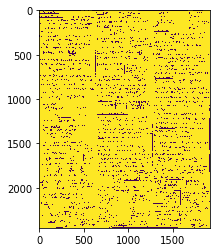

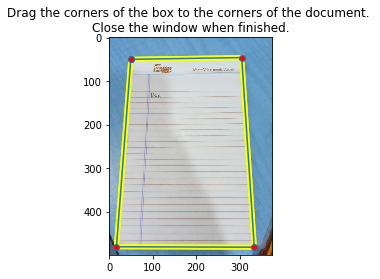

notepad.jfif
Proccessed notepad.jfif


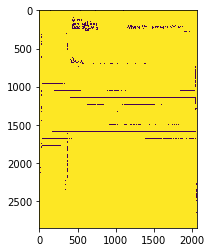

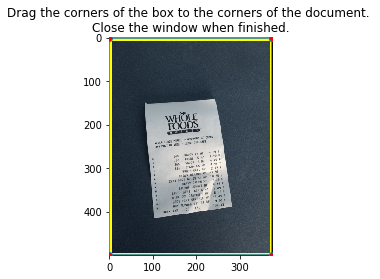

receipt.jpg
Proccessed receipt.jpg


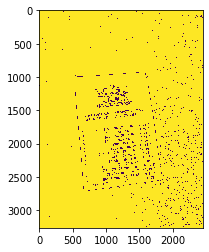

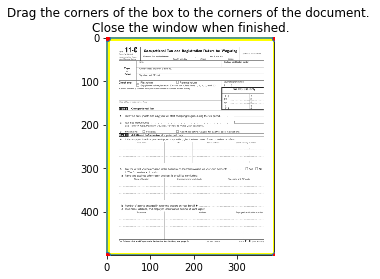

tax.jpeg
Proccessed tax.jpeg


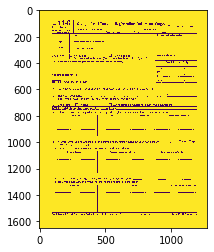

In [6]:
if __name__ == "__main__":

    im_dir = "E:/ssl_invoice/data-1/"
    im_file_path ="E:/ssl_invoice/data-1/cell_pic.jpg"
    interactive_mode =["i"]

    scanner = DocScanner(interactive_mode)
    #valid_formats = [".jpg", ".jpeg", ".jp2", ".png", ".bmp", ".tiff", ".tif"]

    get_ext = lambda f: os.path.splitext(f)[1].lower()
    
    onlyfiles = [ f for f in os.listdir(im_dir) if os.path.isfile(os.path.join(im_dir,f))]
    path = np.empty(len(onlyfiles), dtype=object)
    for n in range(0, len(onlyfiles)):
       path[n] =os.path.join(im_dir,onlyfiles[n])
       scanner.scan(path[n])
    
    # Scan single image specified by command line argument --image <IMAGE_PATH>
    #if im_file_path:
        #scanner.scan(im_file_path)

    # Scan all valid images in directory specified by command line argument --images <IMAGE_DIR>
    #else:
        #im_files = [f for f in os.listdir(im_dir) if get_ext(f) in valid_formats]
        #for im in im_files:
            #scanner.scan(im_dir + '/' + im)

In [11]:
#im_dir = "E:/ssl_invoice/data-1/"
#list_of_images_paths = [os.path.join(im_dir, file) for file in os.listdir(im_dir) 
                       #if file.endswith(".jpg") or file.endswith(".png")]
#invoice_images = [cv2.imread(img_path) for img_path in list_of_images_paths]

In [12]:
#print(invoice_images)